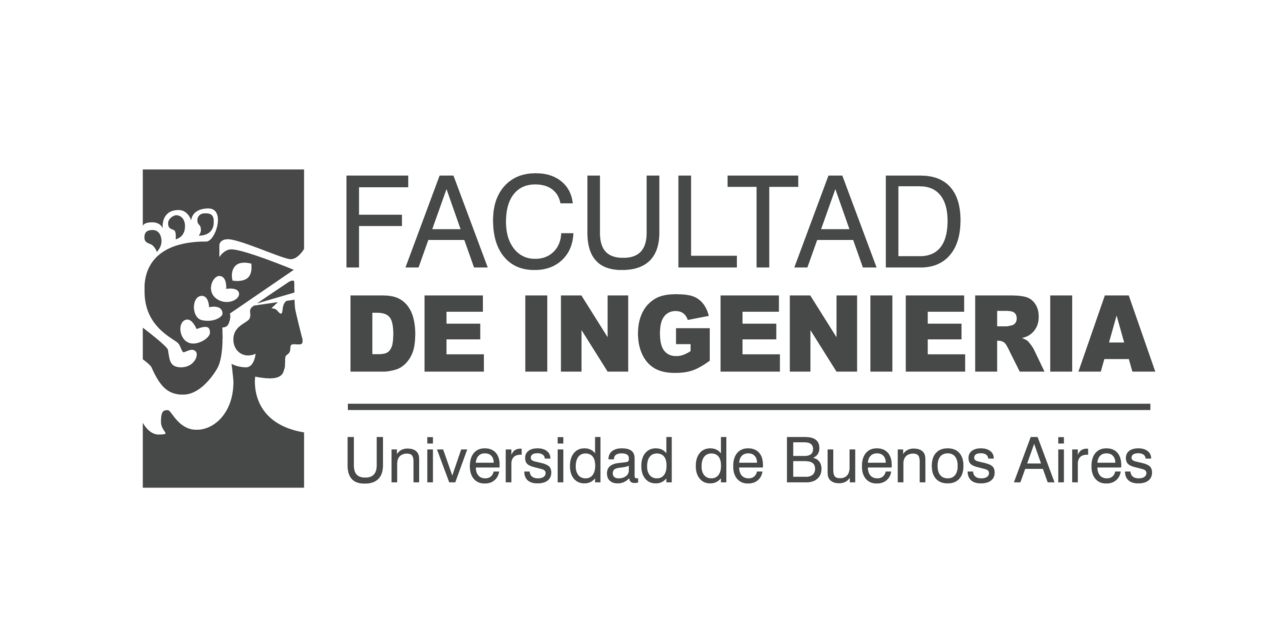

## Aprendizaje Profundo - TP2
### Cohorte 18 - 1er bimestre 2025

**Profesores:** <br />
Dr. Ing. Marcos Maillot - marcos_maillot@yahoo.com.ar <br />
Dr. Antonio Zarauz - hedrergudene@gmail.com <br />
Mg. Ing. Gerardo Vilcamiza - gerardox2000@gmail.com <br />

**Alumnos:** <br />
Mg. Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />

**Repositorio Github**<br />
https://github.com/joagonzalez/ceia-aprendizaje-profundo <br />

## Consigna: **Clasificador de Emociones**

Este segundo TP comienza desde el día después de la clase 5 (2 de abril) y la ventana de entrega estará abierta hasta las **23hs del miércoles 23 de abril (hora de Argentina)**. La resolución del TP es **individual**. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un link a un notebook de google colab (permitir acceso a gerardo.vilcamiza@ieee.org y gvilcamiza.ext@fi.uba.ar) y **se realizará en el siguiente link de google forms: [link](https://forms.gle/XatA691so4eVxZB68)**. Tanto los resultados, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

NO ES NECESARIO QUE NOS ENVIEN COREEO AVISANDO DE LA ENTREGA.

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para este TP2.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP2-Co18.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código, los gráficos y las explicaciones deben quedar guardados y visualizables en el correspondiente notebook.

El objetivo de este trabajo es construir una red neuronal convolucional (CNN) utilizando Pytorch, capaz de clasificar emociones humanas a partir de imágenes faciales. El clasificador deberá identificar una de las 7 emociones básicas: alegría, tristeza, enojo, miedo, sorpresa, disgusto y seriedad. El dataset se encuentra en este link: https://drive.google.com/file/d/10EWwOriegjawQ3evl1nuIldY3pUR-hQc/view?usp=sharing

## Prerequisitos y dependencias

In [ ]:
%pip install gdown
%pip install pandas
%pip install numpy
%pip install torch
%pip install torchvision
%pip install seaborn
%pip install matplotlib
%pip install scikit-learn

In [21]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from collections import defaultdict, Counter
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset


# USAR GPU SI ES POSIBLE
device = "cuda" if torch.cuda.is_available() else "cpu"

# PARAMETROS GLOBALES
BATCH_SIZE = 128
WORKERS = 4
DATASET_AUGMENTED_SIZE = 40000

In [ ]:
# Descarga dataset
!gdown --id 10EWwOriegjawQ3evl1nuIldY3pUR-hQc --output emotions_dataset.zip
!unzip emotions_dataset.zip -d emotions_dataset

## Utils

In [41]:
def dataset_analysis(dataset_path: str, train_counts: dict, test_counts: dict) -> None:
    """
    Analiza el dataset y cuenta la cantidad de imágenes por clase en train y test.

    Args:
        dataset_path (str): Ruta al dataset.
        train_counts (dict): Dict para contar imágenes en train.
        test_counts (dict): Dict para contar imágenes en test.
    """
    for split in ["train", "test"]:
        split_path = os.path.join(dataset_path, split)
        print(f"Processing {split} split {split_path}...")
        if os.path.exists(split_path):
            for emotion in os.listdir(split_path):
                emotion_path = os.path.join(split_path, emotion)
                print(f"Processing emotion {emotion} in {emotion_path}...")
                if os.path.isdir(emotion_path):
                    image_count = len([img for img in os.listdir(emotion_path) if img.endswith(('.jpg'))])
                    if split == "train":
                        train_counts[emotion] += image_count
                    elif split == "test":
                        test_counts[emotion] += image_count
                        
def plot_class_distribution(train_counts: dict, test_counts: dict) -> None:
    """
    Plotea la distribución de clases en train y test.

    Args:
        train_counts (dict): Dict con imágenes en train.
        test_counts (dict): Dict con imágenes en test.
    """
    labels = train_counts.keys()
    train_values = train_counts.values()
    test_values = test_counts.values()
    total_train_images = sum(train_values)
    total_test_images = sum(test_values)

    x = np.arange(len(labels))  
    width = 0.35 

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, train_values, width, label=f'Train (Total: {total_train_images})')
    rects2 = ax.bar(x + width/2, test_values, width, label=f'Test (Total: {total_test_images})')

    ax.set_xlabel('Clases de emociones')
    ax.set_ylabel('# de imagenes')
    ax.set_title('Distribución de clases en train y test')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.show()
    
def mean_std_dataset(dataset_path: str) -> tuple:
    """
    Calcula la media y desviación estándar de un dataset de imágenes.

    Args:
        dataset_path (str): Ruta al dataset.

    Returns:
        tuple: Media y desviación estándar por canal.
    """
    # Transformación base: solo ToTensor para que los valores estén entre 0 y 1
    transform = transforms.ToTensor()

    # Cargar el dataset
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

    n_channels = 3
    mean = torch.zeros(n_channels)
    std = torch.zeros(n_channels)
    total_pixels = 0

    # Calcular media
    print("Calculando media...")
    for images, _ in tqdm(loader):
        batch_samples = images.size(0)
        total_pixels += batch_samples * images.size(2) * images.size(3)  # H * W por imagen
        mean += images.sum(dim=[0, 2, 3])

    mean /= total_pixels

    # Calcular desviación estándar
    print("Calculando desviación estándar...")
    for images, _ in tqdm(loader):
        std += ((images - mean[None, :, None, None]) ** 2).sum(dim=[0, 2, 3])

    std = torch.sqrt(std / total_pixels)

    print(f"Media por canal: {mean}")
    print(f"Desviación estándar por canal: {std}")
    
    return mean, std

def denormalize(img_tensor: torch.Tensor, mean: list, std: list) -> torch.Tensor:
    """
    Desnormaliza un tensor de imagen.

    Args:
        img_tensor (torch.Tensor): Tensor de imagen a desnormalizar.
        mean (list): Lista con medias por canal.
        std (list): Lista con desviaciones estándar por canal.

    Returns:
        torch.Tensor: _description_
    """
    img = img_tensor.clone()
    for z_img, z_mean, z_std in zip(img, mean, std):
        z_img.mul_(z_std).add_(z_mean) # img = img * std + mean
    return img

def show_image(img_tensor: torch.Tensor, mean: list = None, std: list = None) -> None:
    """
    Mostrar una imagen a partir de un tensor de imagen.

    Args:
        img_tensor (torch.Tensor): Tensor de imagen a mostrar.
        mean (list, optional): Lista con medias por canal.
        std (list, optional): Lista con desviaciones estándar por canal.
    """
    if mean is not None and std is not None:
        img_tensor = denormalize(img_tensor, mean, std)

    img_np = img_tensor.permute(1, 2, 0).numpy()  # [C, H, W] → [H, W, C]
    plt.imshow(img_np.clip(0, 1))  # clamp para estar seguros
    plt.axis('off')
    plt.show()

def show_first_images_per_class(
        dataset: torchvision.datasets.ImageFolder, 
        class_names: list,
        mean: float,
        std: float
    ) -> None:
    """
    Mostrar primera imagen de cada clase

    Args:
        dataset (torchvision.datasets.ImageFolder): Dataset a visualizar.
        class_names (list): Lista de clases del dataset.
    """
    images_by_class = {}
    
    # Recorrer el dataset y guardar la primera imagen de cada clase en images_by_class
    for img, label in dataset:
        if label not in images_by_class:
            images_by_class[label] = img
        if len(images_by_class) == len(class_names):
            break

    # Mostrar una imagen por clase en una grilla
    fig, axes = plt.subplots(1, len(class_names), figsize=(15, 4))

    for i, (label, img) in enumerate(images_by_class.items()):
        img = denormalize(img, mean, std) 
        img = img.permute(1, 2, 0).numpy() # [3, H, W] → [H, W, 3]
        axes[i].imshow(img.clip(0, 1))
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def map_counts_to_classnames(counter_dict: dict, class_names: list) -> dict:
    """
    Mapea los indices de las clases a sus nombres.

    Args:
        counter_dict (dict): Dict counter a mapear.
        class_names (list): Dict de nombres de clases.

    Returns:
        dict: _description_
    """
    return {class_names[k]: v for k, v in sorted(counter_dict.items())}

# igual a show_first_images_per_class pero con DataLoader 
def show_first_images_per_class_from_loader(
    dataloader: DataLoader,
    class_names: list,
    mean: list,
    std: list
) -> None:
    """
    Mostrar la primera imagen de cada clase desde un DataLoader con transformaciones activas.

    Args:
        dataloader (DataLoader): Dataloader a visualizar.
        class_names (list): Nombre de las clases dentro del dataset que tiene el DataLoader.
        mean (list): Media por canal.
        std (list): Desviación estándar por canal.
    """
    images_by_class = {}

    for images, labels in dataloader:
        for img, label in zip(images, labels):
            label = label.item()
            if label not in images_by_class:
                images_by_class[label] = img
            if len(images_by_class) == len(class_names):
                break
        if len(images_by_class) == len(class_names):
            break

    # Mostrar una imagen por clase en una grilla
    fig, axes = plt.subplots(1, len(class_names), figsize=(15, 4))

    for i, (label, img) in enumerate(sorted(images_by_class.items())):
        img = denormalize(img, mean, std)
        img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img.clip(0, 1))
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


## 1. Preprocesamiento de Datos

Antes de entrenar el modelo, se debe analizar qué tipo de preprocesamiento se debe aplicar a las imágenes. Para esto, se puede considerar uno o más aspectos como:

- Tamaño
- Relación de aspecto
- Color o escala de grises
- Cambio de dimensionalidad
- Normalización
- Balanceo de datos
- Data augmentation
- etc.

Sean criteriosos y elijan las técnicas que consideren pertinentes.

Recomendación: usar `torchvision.transforms` para facilitar el preprocesamiento.

In [ ]:
# Dataset path
dataset_path = "emotions_dataset/dataset_emociones"

# Inicializamos dicts en int 0
train_counts = defaultdict(int)
test_counts = defaultdict(int)

dataset_analysis(dataset_path, train_counts, test_counts)   

print("Counts por emocion para train:")
for emotion, count in train_counts.items():
    print(f"{emotion}: {count}")

print("\nCounts por emocion para test:")
for emotion, count in test_counts.items():
    print(f"{emotion}: {count}")

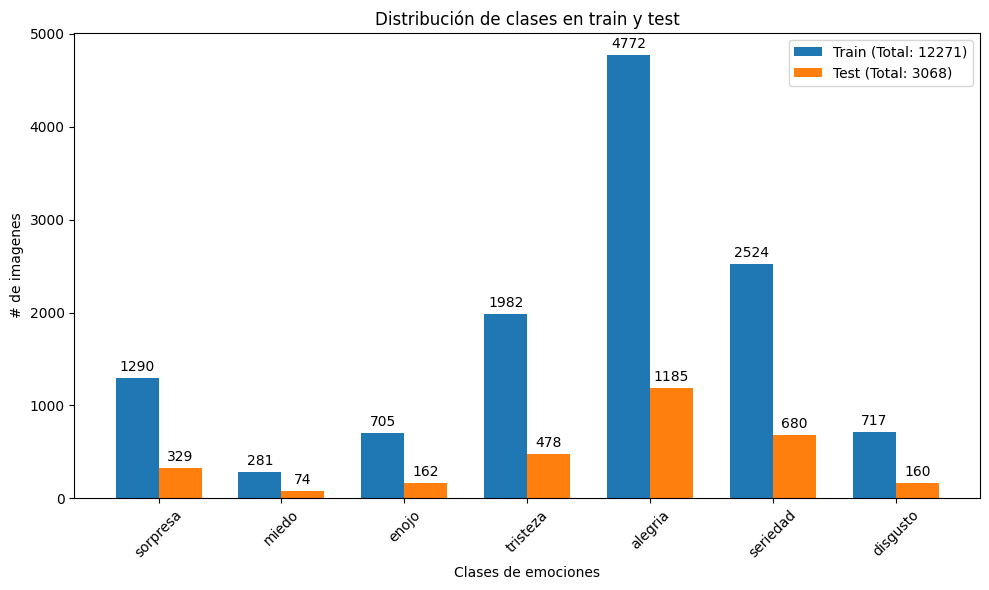

In [43]:
plot_class_distribution(train_counts, test_counts)

Se observa un desbalanceo considerable en las clases para ambos splits (train, test). Se pueden aplicar transformaciones con torch.vision para balancear aplicando rotaciones, cambios de escala, transformaciones en escalas de grises o colores, etc. Vemos que alegría es la mas desbalanceada positivamente en ambos dataset y miedo la que menos frecuencia tiene, se entiende que esto puede explicarse ya que las personas activamente propoician fotos cuando estan alegres y las evitan en el otro extremo.

In [44]:
# Para evitar data leakage obtengo mean y std de train dataset nada mas
train_mean, train_std = mean_std_dataset(dataset_path + "/train")
# mean_std_dataset(dataset_path + "/test")

Calculando media...


100%|██████████| 96/96 [00:01<00:00, 59.16it/s]


Calculando desviación estándar...


100%|██████████| 96/96 [00:02<00:00, 47.70it/s]

Media por canal: tensor([0.5752, 0.4495, 0.4012])
Desviación estándar por canal: tensor([0.2652, 0.2422, 0.2407])


In [45]:
# Cargamos train y test con los todos los canales para inspección visual inicial
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

train_dataset = datasets.ImageFolder(root=dataset_path + '/train', transform=transform)
test_dataset = datasets.ImageFolder(root=dataset_path + '/test', transform=transform)

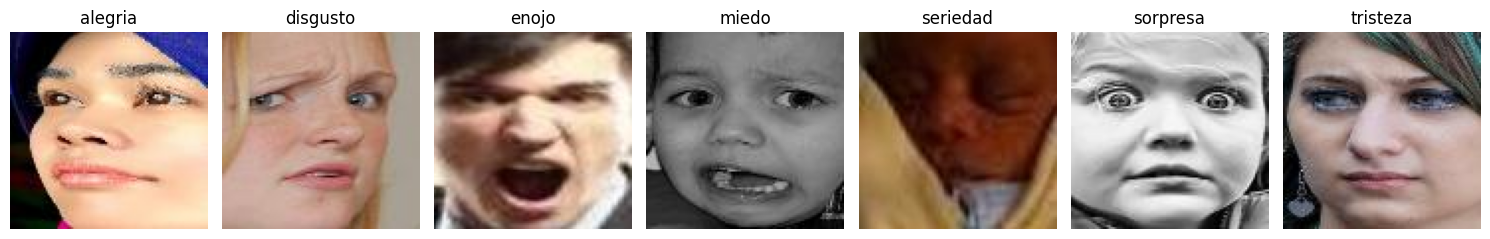

In [46]:
show_first_images_per_class(train_dataset, train_dataset.classes, train_mean, train_std)

Como se dijo anteriormente. ~12k imagenes para 7 clases y con el desbalance observado parece poco para entrenar una red neuronal para esta tarea. Se realizara data augmentation con transformaciones. De esta manera atacaremos 3 frentes:
- Disminuir desbalance de clases
- Aumentar la cantidad de datos para mejorar la performance de la red neuronal en la tarea de clasificación
- Hacer al modelo a entrenar mas robustos a las transfromaciones aplicadas (por ejemplo, podra reconocer mejor emociones de caras rotadas si hacemos augmentation con transformaciones de rotación)

In [47]:
# 1- Se aplican distintas transformaciones para el dataset de train y test
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(100, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 2- Se cargan los datasets de train y test con las transformaciones
train_dataset = datasets.ImageFolder(root=dataset_path + '/train', transform=train_transform)
test_dataset = datasets.ImageFolder(root=dataset_path + '/test', transform=test_transform)

# 3- Se splitea el dataset de train en train y validation para entrenamiento, test se deja para tarea final de evaluación
# Obtener las etiquetas de las imágenes en el dataset de entrenamiento
train_targets = [label for _, label in train_dataset]

# Dividir el dataset en train y validation usando train_test_split
train_indices, val_indices = train_test_split(
    range(len(train_targets)),
    test_size=0.3,
    stratify=train_targets,
    random_state=42
)

# Crear los datasets a partir de los índices
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

# 4- Se utiliza data augmentation con WeightedRandomSampler para balancear el dataset
# Obtener las etiquetas del subset de entrenamiento
targets = [train_dataset[i][1] for i in train_indices]

# Calcular pesos por clase
class_counts = Counter(targets)
train_num_samples = len(targets)
val_num_samples = len(val_subset)
class_weights = {cls: train_num_samples / count for cls, count in class_counts.items()}

# Crear los pesos por muestra
sample_weights = [class_weights[label] for label in targets]
sample_weights = torch.DoubleTensor(sample_weights)

# Usar WeightedRandomSampler para balancear el dataset
sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=DATASET_AUGMENTED_SIZE,
                                replacement=True)

# 5- Se crean los DataLoaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, num_workers=WORKERS, sampler=sampler)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

print(f"Pesos por clase: {class_weights}")
print(f"Tamaño de train dataset original: {train_num_samples}")
print(f"Tamaño de train dataset con augmentation: {DATASET_AUGMENTED_SIZE}")
print(f"Tamaño de validation dataset: {val_num_samples}")
print(f"Tamaño de test dataset: {len(test_dataset)}")

Pesos por clase: {1: 17.109561752988046, 4: 4.860780984719864, 6: 6.192501802451334, 0: 2.571556886227545, 3: 43.598984771573605, 2: 17.421906693711968, 5: 9.511627906976743}
Tamaño de train dataset original: 8589
Tamaño de train dataset con augmentation: 40000
Tamaño de validation dataset: 3682
Tamaño de test dataset: 3068


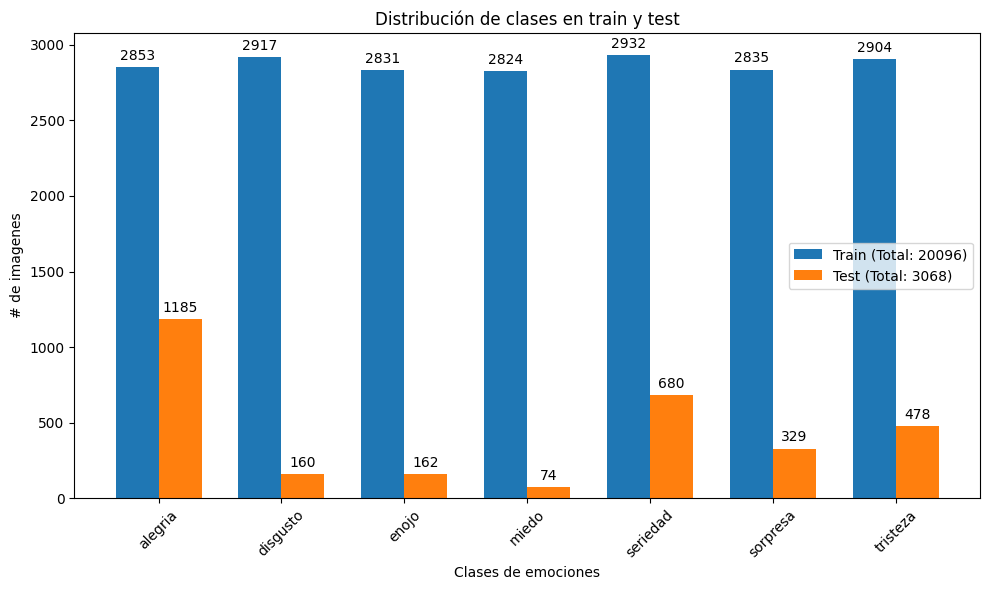

In [48]:
# Probamos el DataLoader y WeightedRandomSampler para ver balanceo de clases
sampled_labels = []
for i, (_, labels) in enumerate(train_loader):
    sampled_labels.extend(labels.numpy())
    if len(sampled_labels) >= DATASET_AUGMENTED_SIZE / 2:  # tomamos una muestra
        break

# Contamos cuántas veces aparece cada clase
balanced_train_counts = Counter(sampled_labels)

train_counts_named = map_counts_to_classnames(balanced_train_counts, train_dataset.classes)
test_counts_named = map_counts_to_classnames(Counter(test_dataset.targets), test_dataset.classes)

plot_class_distribution(train_counts_named, test_counts_named)

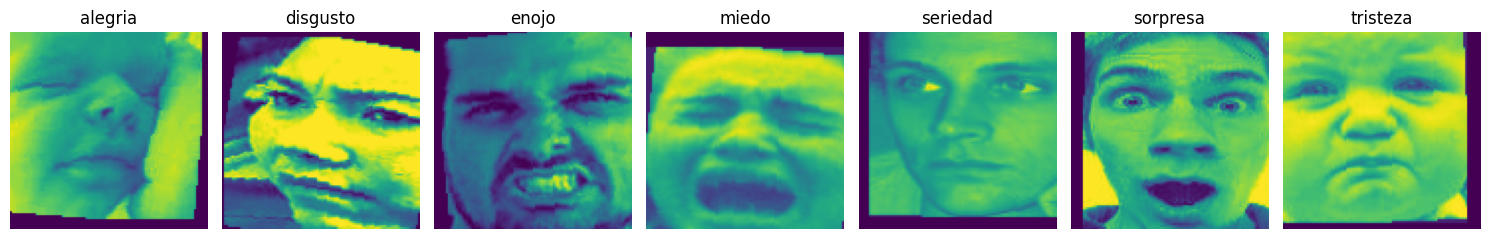

In [49]:
show_first_images_per_class_from_loader(train_loader, train_dataset.classes, [0.5], [0.5])

## 2. Construcción y entrenamiento del Modelo CNN

- Construir una red neuronal convolucional desde cero, sin usar modelos pre-entrenados.
- Analizar correctamente qué funciones de activación se deben usar en cada etapa de la red, el learning rate a utilizar, la función de costo y el optimizador.
- Cosas como el número de capas, neuronas, tanaño de kernel, entre otros, queda a criterio de ustedes.

## 3. Evaluación del Modelo

El modelo entrenado debe ser evaluado utilizando las siguientes métricas:

- **Accuracy**:
  - Reportar el valor final en el conjunto de test.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **F1 Score**:
  - Reportar el valor final en el conjunto de test.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **Costo (Loss)**:
  - Mostrar una gráfica de evolución del costo por época para entrenamiento y validación.

- **Classification report**
  - Mostrar la precisión, recall y F1 score por cada clase usando `classification_report`

- **Matriz de confusión**:
  - Mostrar la matriz de confusión absoluta (valores enteros).
  - Mostrar la matriz de confusión normalizada (valores entre 0 y 1 por fila).

Se recomienda utilizar `scikit-learn` para calcular métricas como accuracy, F1 score, el Classification report y las matrices de confusión. Las visualizaciones pueden realizarse con `matplotlib` o `seaborn`, separando claramente los datos de entrenamiento y validación en las gráficas.

 ## 4. Prueba con Imágenes Nuevas

Subir al menos 3 imágenes personales (con el rostro de ustedes o de otras personas), que no formen parte del dataset de entrenamiento ni de testeo.

- Cada imagen debe representar una emoción distinta.

- Aplicar el mismo preprocesamiento que se usó para el dataset.

- Pasar las imágenes por el modelo entrenado y mostrar:

  - La imagen original (preprocesada)

  - La clase inferida por el modelo

- Redactar conclusiones y comentarios finales